# Figure 4a

Correlations stuff

In [1]:
import os
import sys

import numpy as np
import pandas as pd

from tqdm import tqdm
from IPython.display import clear_output

import matplotlib as mpl 
import matplotlib.pyplot as plt

sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
import icenumerics as ice

import auxiliary as aux
import montecarlo_tools as mc
import chirality_tools as chir
ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Parameters

In [3]:
quench_time = 300*ureg.s
evolution_time = 60*ureg.s
total_time = quench_time + evolution_time
#sim_path = '/mnt/e/stuckgs/data/sims'
sim_path = '../data/sims/'

params = {
    "particle_radius":1.4*ureg.um,
    "particle_susceptibility":0.4,
    "particle_diffusion":0.14*ureg.um**2/ureg.s,
    "particle_temperature":300*ureg.K,
    "particle_density":1000*ureg.kg/ureg.m**3,

    "trap_sep":3*ureg.um,
    "trap_height":8*ureg.pN*ureg.nm,
    "trap_stiffness":100e-3*ureg.pN/ureg.nm,
    "height_spread":0,
    "susceptibility_spread":0,
    "isperiodic":True,

    "total_time":total_time,
    "framespersec":20*ureg.Hz,
    "dt":0.1*ureg.ms,
    "max_field":10*ureg.mT,
    "sim_temp":300*ureg.K,
    "sim_dipole_cutoff":40*ureg.um,
}

params["lattice_constant"] = params["trap_sep"]+(2*params["particle_radius"]+1*ureg.um)*np.sqrt(2)

params['mu0'] = (4*np.pi)*1e-7 * ureg.H/ureg.m
params['m'] = np.pi * (2*params['particle_radius'])**3 *params['particle_susceptibility']*params['max_field']/6/params['mu0']
params['kb'] = 1.380649e-23 * ureg.J / ureg.K
params['kbT'] = (params['kb'] * params['sim_temp']).to(ureg.nm * ureg.pN)

## Computing $r_\parallel$

Do not run this cell like a fool

In [9]:
def get_rp_on_realization(sim_path,realization):
    ctrj = pd.read_csv(os.path.join(sim_path,'30','ctrj',f'xtrj{realization}.csv'), index_col=[0,1])
    particles = ctrj.index.get_level_values('id').unique().to_list()
    frames = ctrj.index.get_level_values('frame').unique().to_list()
    sframes = frames[::5]
    
    ts = []

    for cur_particle in tqdm(particles):

        single_ts = [aux.get_rparalell(ctrj,cur_particle,frame) for frame in sframes]
        ts.append(single_ts)
            
    dfts = pd.DataFrame(data = np.array(ts).transpose())
    pnumbers = list(dfts.columns)
    dfts['frame'] = sframes
    dfts['realization'] = [realization]*len(dfts)
    dfts = dfts[['realization','frame'] + pnumbers]
    
    file2make = os.path.join(sim_path,'rparallels.csv')
    
    if realization == 1:
        dfts.to_csv(file2make,index=False)
    else:
        dfts.to_csv(file2make,mode='a',index=False, header=False)
    
    return None

In [ ]:
get_rp_on_realization(sim_path,1)

## Correlations

Here I will generalte all the correlation timeseries for all realizations for all particles.

In [6]:
data = pd.read_csv(os.path.join(sim_path,'rparallels.csv'), index_col=[0,1])
data

0         1         2         3         4         5  \
realization frame                                                              
1           0     -1.50000 -1.500000  1.500000  1.500000  1.500000  1.500000   
            5     -1.36340 -1.468699  1.409801  1.371201  1.477997  0.806602   
            10    -1.49675 -0.899199  1.405701  1.337200  1.443298  1.019600   
            15    -1.43174 -1.103700  1.345100  1.271799  1.490898  1.191002   
            20    -1.47243 -1.134600  1.214100  1.487400  1.141399  0.748203   
...                    ...       ...       ...       ...       ...       ...   
5           8375  -1.22677  1.157500 -1.432899  1.306200 -0.947903  1.046501   
            8380  -1.12195  0.986100 -1.434799  1.276600 -0.931000  1.026703   
            8385  -1.15756  1.287300 -1.489799  1.363100 -0.968903  0.943802   
            8390  -1.15246  1.353800 -1.496599  1.257601 -0.897003  0.878502   
            8395  -1.19238  1.077800 -1.428699  1.328501 -0.962902  0.922703   

                          6         7         8         9  ...      1790  \
realization frame                                          ...             
1           0     -1.500000  1.500000  1.500000 -1.500000  ... -1.500000   
            5     -0.957699  1.353600  1.453598 -1.322998  ... -1.353012   
            10    -0.707699  1.410202  1.502502 -1.371498  ... -1.102005   
            15    -0.090199  1.121201  1.405998 -1.495102  ... -1.084000   
            20    -0.195499  0.820099  1.431900 -1.428200  ... -1.289001   
...                     ...       ...       ...       ...  ...       ...   
5           8375  -1.339600  1.427299 -1.306801  1.173203  ...  1.530991   
            8380  -1.345299  1.470604 -1.331596  1.102501  ...  1.539001   
            8385  -1.285900  1.440399 -1.193604  1.181900  ...  1.532990   
            8390  -1.309799  1.507004 -1.254898  1.171097  ...  1.526993   
            8395  -1.334400  1.495499 -1.361298  1.230400  ...  1.535995   

                       1791      1792      1793      1794      1795      1796  \
realization frame                                                               
1           0     -1.500000  1.500000 -1.500000 -1.500000 -1.500000  1.500000   
            5     -1.289001  1.235001 -1.354004 -1.458008 -1.264999  1.136002   
            10    -1.473007  0.710999 -1.335007 -1.434998 -1.483002  1.384995   
            15    -1.322006  1.054001 -1.362000 -1.437012 -1.334000  1.498001   
            20    -1.439011  0.824997 -1.427002 -1.375000 -1.249008  1.097000   
...                     ...       ...       ...       ...       ...       ...   
5           8375  -1.529999 -1.493011 -1.522003  1.552002 -1.520004 -1.522003   
            8380  -1.518005 -1.521011 -1.531006  1.516998 -1.516006 -1.529007   
            8385  -1.535004 -1.500000 -1.520004  1.526993 -1.516006 -1.514999   
            8390  -1.516998 -1.510010 -1.531998  1.531998 -1.512009 -1.524002   
            8395  -1.535004 -1.493011 -1.516998  1.539001 -1.512009 -1.531998   

                       1797      1798      1799  
realization frame                                
1           0      1.500000 -1.500000 -1.500000  
            5      1.266998 -1.285004 -1.156006  
            10     1.405991 -1.339005 -0.934998  
            15     1.345001 -1.324005 -0.977005  
            20     0.944000 -1.488007 -0.886002  
...                     ...       ...       ...  
5           8375  -1.512009  1.537003 -1.535004  
            8380  -1.503998  1.539001 -1.541000  
            8385  -1.518005  1.535995 -1.547012  
            8390  -1.508011  1.541992 -1.533005  
            8395  -1.516006  1.537994 -1.531006  

[8400 rows x 1800 columns]

In [147]:
realizations = data.index.get_level_values('realization').unique().to_list()

h = 20
intervals = [(0, 20),
 (20, 40),
 (40, 60),
 (60, 80),
 (80, 100),
 #(100, 120),
 #(120, 140),
 #(140, 160),
 (160, 180),
 #(180, 200),
 #(200, 220),
 (220, 240),
 #(240, 260),
 #(260, 280),
 (280, 300)]


In [68]:
def correlate_realization(sim_path,data,realization,interval,s,e):
    """
        This calculates the correlations functions for all particles in a given time interval.
        Saves all the data.
    """
    
    # Selecting the appropiate realization and its frames
    cdata = data.loc[idx[realization,:]]
    sframes = cdata.index.get_level_values('frame').unique().to_list()
    particle_ids = data.columns
    
    # Selecting all the particles time-selies
    cts = cdata[particle_ids].to_numpy().transpose()
    subselframes, correlations = aux.correlate_bframes(params,cts,sframes,stime=s,etime=e)

    # Making the appropiate df
    corr_df = pd.DataFrame(np.array(correlations).transpose()) # Putting each time-series as columns
    numbered = list(corr_df.columns)
    corr_df['frame'] = subselframes
    corr_df['realization'] = [realization] * len(subselframes)
    corr_df[['realization','frame'] + numbered]

    if realization == 1:
        corr_df.to_csv(os.path.join(sim_path,f'corr{interval}.csv'), index=False)
    else:
        corr_df.to_csv(os.path.join(sim_path,f'corr{interval}.csv'), index=False, header=False, mode='a')
    


In [69]:
corr_path = '../data/figs/correlations'
for i,(s,e) in enumerate(intervals):
    for realization in realizations:
        
        correlate_realization(corr_path,data,realization,i,s,e)

## Averages

Now it is time to load them one by one and take the averages, std, normalize and stuff.

In [139]:
for interval in range(8):
    avs = []
    for realization in realizations:
        corr_int = pd.read_csv(os.path.join(corr_path,f'corr{interval}.csv'),index_col=['realization','frame'])
        frames = corr_int.index.get_level_values('frame').unique().to_numpy()
        dt = (frames - frames[0]) / params['framespersec'].magnitude
        
        particle_average = corr_int.loc[idx[realization,:]].mean(axis=1)
        particle_average = particle_average / particle_average.max()
        avs.append(particle_average.to_list())

    df = pd.DataFrame( np.array(avs).mean(axis=0), columns=['av'])
    df['dt'] = dt
    df['interval'] = [interval] * len(frames)

    if interval == 0:
        df.to_csv(os.path.join(corr_path,'global.csv'), index=False)
    else:
        df.to_csv(os.path.join(corr_path,'global.csv'), index=False,mode = 'a', header=False)



## Visualization

In [157]:
corravs = pd.read_csv(os.path.join(corr_path,'global.csv'), index_col=['interval','dt'])
nintervals = corravs.index.get_level_values('interval').unique().to_list()

In [163]:
rate = params['max_field']/quench_time
fields = [np.round(i[0] * rate.magnitude, decimals=2) for i in intervals]
fields


[0.0, 0.67, 1.33, 2.0, 2.67, 5.33, 7.33, 9.33]

In [ ]:
legend = f"{fields[ninterval]} mT"

/tmp/ipykernel_319/3683278242.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='B [ mT ]')


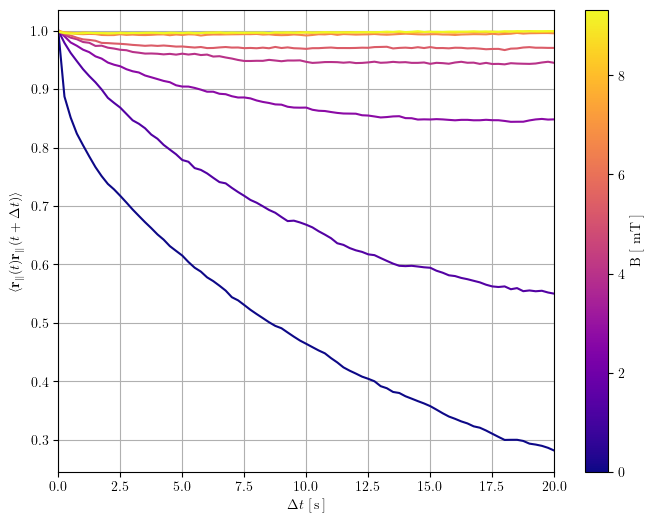

In [177]:
fig, ax = plt.subplots(figsize = (8,6))
cmap = plt.get_cmap('plasma')

for interval, (i,B) in zip(nintervals, enumerate(fields)):
    color =  cmap(i / (len(fields) - 1))
    avi = corravs.loc[idx[interval,'av']]
    ax.plot(avi.index.to_list(),avi.to_list(), color=color)

ax.set_xlabel("$\\Delta t$ [\,s\,]")
ax.set_xlim(0,h)
ax.set_ylabel("$\\langle \mathbf{r}_\parallel(t) \mathbf{r}_\parallel(t+\\Delta t)\\rangle$")
ax.grid()
#ax.legend()

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(fields)))
sm.set_array([])
plt.colorbar(sm, label='B [ mT ]')

fig.savefig(os.path.join('../data/figs','fig4a.png'),dpi=300,bbox_inches='tight')
fig.savefig(os.path.join('../data/figs','fig4a.pdf'))

plt.show()

## Energy as a function of time

In [ ]:
def calulate_energy_at_frame_rl(params,data_path,size,frame,realization):
    
    params['size'] = size
    
    trj = pd.read_csv(os.path.join(data_path,str(size),'trj',f'trj{realization}.csv'), index_col=[0,1])
    #last_frame = trj.index.get_level_values('frame').unique()[-1]
    particles = aux.get_coordinates_at_frame(trj,frame)
    dis_energy = aux.calculate_energy(params,particles)
    return dis_energy